# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pprint import pprint

In [154]:
LOGIN_FILE_PATH = './logins.json'
df_login = pd.read_json(LOGIN_FILE_PATH)

In [155]:
# Inspect DataFrame
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [156]:
# Count logins based on 15-minute time intervels
df_login_count = df_login.resample(rule='15T', on='login_time').count()
df_login_count.columns = ['counts']
df_login_count.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [157]:
def plot_login_counts(df):
    plot_type = 'line'
    figure_size = (15, 5)
    df.plot(kind=plot_type, figsize=figure_size)
    plt.xlabel('Login Time')
    plt.ylabel('Counts')
    plt.show()

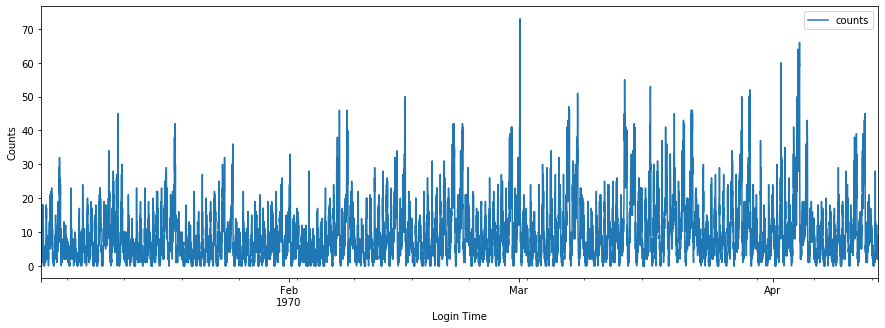

In [158]:
# Plot the whole data
plot_login_counts(df_login_count)

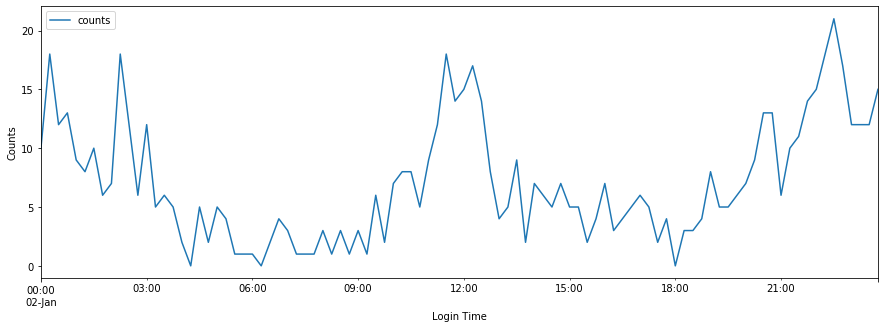

In [159]:
# Plot one day
plot_login_counts(df_login_count.loc['1970-01-02':'1970-01-02'])

It's hard to see the counts as it's 15-minute intervels.

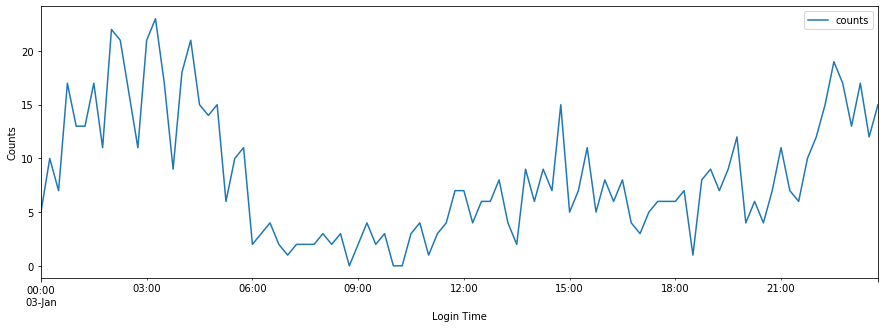

In [160]:
# Next day
plot_login_counts(df_login_count.loc['1970-01-03':'1970-01-03'])

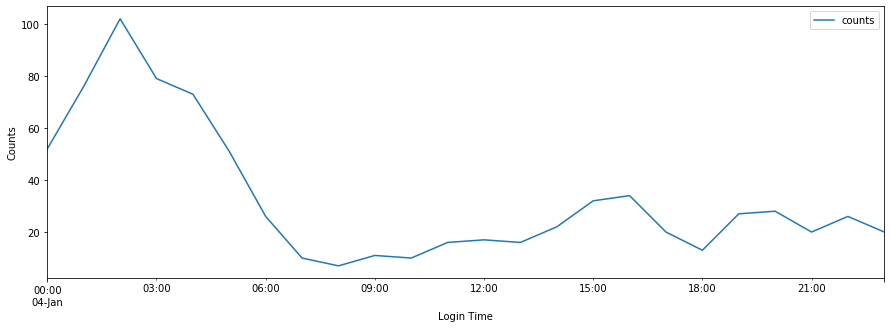

In [161]:
# Plot one week
plot_login_counts(df_login_count_by_hour.loc['1970-01-04':'1970-01-04'])

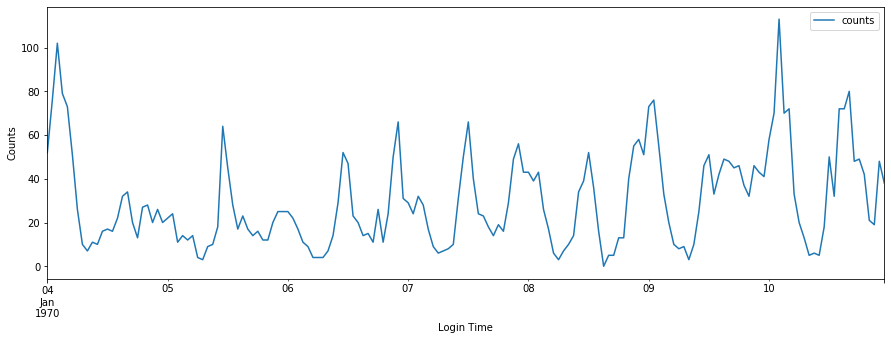

In [162]:
# Next week
plot_login_counts(df_login_count_by_hour.loc['1970-01-04':'1970-01-10'])

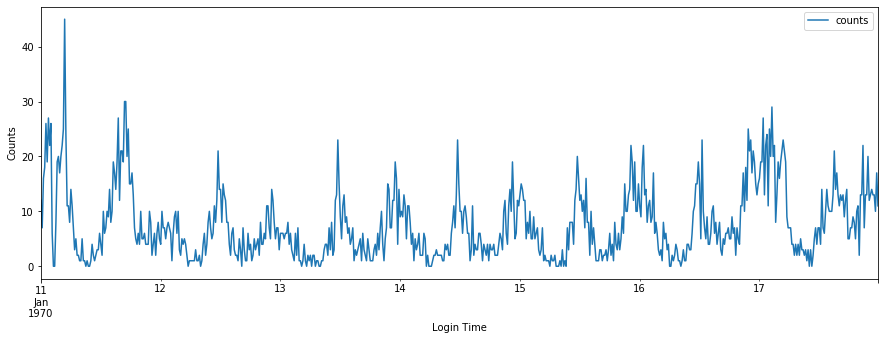

In [163]:
plot_login_counts(df_login_count.loc['1970-01-11':'1970-01-17'])

We can see that hours around 12AM and 12PM are usually the peak hours of the day.

Weekend usually has more logins around 12AM than weekdays.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

========================= ANSWER =========================

After reimbursing the toll costs, driver partners should be more willing to drive to another city to take orders. Because of the circadian rhythms in each city, drivers will have the tendency to drive to Ultimate Gotham and take orders there at night, then drive to Ultimate Metropilis and take orders during daytime. This tendency would result in drivers taking more orders which causes the increase of the login counts.

Therefore, I would choose __login counts__ as the key measurement.

As it may take some time for the drivers to know the reimbursement of the toll costs, the experiment duration could be between 2 weeks and 1 month. The experiment could take longer than 1 month based on the timeline. Ultimate Technologies should notify driver partners of the toll cost reimbursement and recommend them to take orders from another city from Day 1.

After the experiment, the login counts from the experiment duration and the counts from the same duration before the experiment should be used to perform two-sample T test.

Ultimate Technologies should then suggest the city operations team to compare the increase of revenue with the lose of toll costs to determine if the city should reimburse the costs.

# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [164]:
USER_FILE_PATH = './ultimate_data_challenge.json'
df_users = pd.read_json(USER_FILE_PATH)

In [165]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Adress with missing data

Based on the above information, three columns have missing data:
* avg_rating_of_driver: missing about 20% of the data, will fill the value with the mean of rating
* phone: missing about 0.8% of the data, will drop the row with null value
* avg_rating_by_driver: missing about 0.4%, will drop the row with null value

In [166]:
# Fill NAN for avg_rating_of_driver
mean_rating_of_driver = round(df_users['avg_rating_of_driver'].mean(), 1)
df_users['avg_rating_of_driver'] = df_users['avg_rating_of_driver'].fillna(mean_rating_of_driver)

# Drop NAN for phone and avg_rating_by_driver
df_users = df_users.dropna()

df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49406 non-null  object 
 1   trips_in_first_30_days  49406 non-null  int64  
 2   signup_date             49406 non-null  object 
 3   avg_rating_of_driver    49406 non-null  float64
 4   avg_surge               49406 non-null  float64
 5   last_trip_date          49406 non-null  object 
 6   phone                   49406 non-null  object 
 7   surge_pct               49406 non-null  float64
 8   ultimate_black_user     49406 non-null  bool   
 9   weekday_pct             49406 non-null  float64
 10  avg_dist                49406 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [167]:
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Add is_active Label

In [168]:
# Find the latest last_trip_date
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date'])
lastest_trip_date = df_users['last_trip_date'].max()
lastest_trip_date

Timestamp('2014-07-01 00:00:00')

In [169]:
# Find account activate threshold date, if user's last_trip_date is larger than threshold date, user is considered active
account_active_threshold_date = lastest_trip_date - pd.Timedelta(days=30)
account_active_threshold_date

Timestamp('2014-06-01 00:00:00')

In [170]:
df_users['is_active'] = df_users.apply(lambda x: x['last_trip_date'] > account_active_threshold_date, axis=1)

In [171]:
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


# Calculate Retention Rate

In [172]:
# Calculate retention rate
total_users = df_users.shape[0]
num_active_users = df_users[df_users['is_active'] == True].shape[0]
retention_rate = round(num_active_users / total_users, 3)
retention_rate

0.367

# Convert Non-Numeric Features

In [173]:
# Covert time series features
df_users['signup_date'] = pd.to_datetime(df_users['signup_date'])

df_users['signup_year'] = df_users['signup_date'].dt.year
df_users['signup_month'] = df_users['signup_date'].dt.month
df_users['signup_day'] = df_users['signup_date'].dt.day

df_users = df_users.drop('signup_date', axis=1)

df_users.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active,signup_year,signup_month,signup_day
0,King's Landing,4,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,2014,1,25
1,Astapor,0,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,2014,1,29
2,Astapor,3,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,2014,1,6
3,King's Landing,9,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,2014,1,10
4,Winterfell,14,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,2014,1,27


In [174]:
# As last_trip_date is highly correlated with the label, it will not be used as features
df_users = df_users.drop('last_trip_date', axis=1)
df_users.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active,signup_year,signup_month,signup_day
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True,2014,1,25
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False,2014,1,29
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False,2014,1,6
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True,2014,1,10
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False,2014,1,27


In [175]:
# Convert categorical values
df_users = pd.get_dummies(df_users)
df_users.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active,signup_year,signup_month,signup_day,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,True,2014,1,25,0,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,False,2014,1,29,1,0,0,1,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,False,2014,1,6,1,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,True,2014,1,10,0,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,False,2014,1,27,0,0,1,1,0


# Build Prediction Model

In [196]:
y = df_users['is_active'].values
X = df_users.drop('is_active', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.fit_transform(X_test)

## Linear SVC

In [197]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

/Users/aodanx/opt/anaconda3/envs/ultimate-challenge/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [198]:
lsvc.score(X_test, y_test)

0.7236874386653582

## Random Forest

In [199]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [200]:
rfc.score(X_test, y_test)

0.7798699705593719

Because the features have both numeric and categorical values, the 'distance' on which SVM relies is not meaningful in the context. Random forest should have better performance in this case. The above results also show that random forest has a better score on validation set.

# Insights From The Model

In [208]:
# Add feature names to importances
feature_names = df_users.drop('is_active', axis=1).columns
feature_importances = {}
for feature_name, feature_importance in zip(feature_names, rfc.feature_importances_):
    feature_importances[feature_name] = feature_importance
    
# Sort importances
# feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1])}
pprint(feature_importances)

{'avg_dist': 0.20601976711657802,
 'avg_rating_by_driver': 0.10584521422254038,
 'avg_rating_of_driver': 0.07327270583949276,
 'avg_surge': 0.061491738870838926,
 'city_Astapor': 0.016718582902742668,
 "city_King's Landing": 0.051317976820730485,
 'city_Winterfell': 0.01086050872059571,
 'phone_Android': 0.021399670294380467,
 'phone_iPhone': 0.0189018347018261,
 'signup_day': 0.1347358810226753,
 'signup_month': 0.0,
 'signup_year': 0.0,
 'surge_pct': 0.07881237039993289,
 'trips_in_first_30_days': 0.07272069105517157,
 'ultimate_black_user': 0.0326209723474653,
 'weekday_pct': 0.11528208568502948}


The model shows that the following three features are most important in terms of predicting user retention:

__avg_dist__: the average distance in miles per trip taken in the first 30 days after signup

As it's not common for riders to take long distance trip, one of the possible interpretions for this feature is the number of trips riders took. Riders who take more trips in their first month tend to have higher chance of retention.

To inscrease the average distance, Ultimate can give discounts to the riders in their first month after signup.

__avg_rating_by_driver__: the rider’s average rating over all of their trips

Riders with higher ratings are more likely to retain. These riders usually 1) give tips, 2) behave properly, 3) have great conversation with drivers.

Potential high rating riders are likely to locate closer to each other. Ultimate can target new customers who are geographically close to the existing high rating riders.

__avg_rating_of_driver__: the rider’s average rating of their drivers over all of their trips

Riders who like to give higher ratings to the drivers usually have better experience.

Ultimate should keep a high standard of the drivers to retain the great riding experience, which would retain more users.